# Maximum Drawdown: Measuring Your Worst Case

**Time:** 15 minutes

**Prerequisites:** 04_returns_and_performance.ipynb

---

The Sharpe Ratio tells you about average risk, but investors often care more about **worst-case scenarios**. Maximum Drawdown answers the question: "What's the most I could have lost?"

## What is a Drawdown?

A **drawdown** is the decline from a peak (highest point) to a trough (lowest point) before a new peak is reached.

**Drawdown Formula:**

$$\text{Drawdown}_t = \frac{\text{Current Value} - \text{Peak Value}}{\text{Peak Value}} \times 100\%$$

Or equivalently:

$$\text{Drawdown}_t = \frac{V_t - \max(V_0, V_1, ..., V_t)}{\max(V_0, V_1, ..., V_t)}$$

**Mental Model: The Mountain Climber**

Imagine climbing a mountain. Every time you reach a new highest point, that becomes your "peak." If you then descend, your drawdown is how far you've fallen from that peak. You're always measuring from your highest point so far, not from where you started.

## Maximum Drawdown (MDD)

**Maximum Drawdown** is the largest drawdown observed over a period.

$$\text{MDD} = \min_{t \in [0,T]} \left( \frac{V_t - \text{Peak}_t }{\text{Peak}_t} \right)$$

**Why It Matters:**

1. **Behavioral Finance:** Most investors panic and sell at the bottom
2. **Risk Tolerance:** Can you stomach a 50% drop?
3. **Recovery Math:** A 50% loss requires a 100% gain to recover


In [1]:
# Install required packages
!pip install -q yfinance pandas numpy matplotlib

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_drawdown(prices):
    """Calculate drawdown series from price data.

    Args:
        prices: Series of prices

    Returns:
        Dictionary with drawdown metrics
    """
    # Calculate running maximum (the "peak" at each point)
    running_max = prices.cummax()

    # Calculate drawdown at each point
    drawdown = (prices - running_max) / running_max

    # Maximum drawdown
    max_drawdown = drawdown.min()

    # When did max drawdown occur?
    max_dd_end = drawdown.idxmin()

    # When was the peak before max drawdown?
    if max_dd_end == prices.index[0]:
        max_dd_start = max_dd_end
    else:
        max_dd_start = prices[:max_dd_end].idxmax()

    return {
        'drawdown_series': drawdown,
        'running_max': running_max,
        'max_drawdown': max_drawdown,
        'max_dd_pct': max_drawdown * 100,
        'peak_date': max_dd_start,
        'trough_date': max_dd_end,
        'peak_value': prices[max_dd_start],
        'trough_value': prices[max_dd_end]
    }

# Example: Calculate drawdown for a stock
ticker = "AAPL"
stock = yf.Ticker(ticker)
hist = stock.history(period="2y")
prices = hist['Close']

dd_results = calculate_drawdown(prices)

print(f"Maximum Drawdown Analysis: {ticker}")
print("=" * 50)
print(f"Maximum Drawdown: {dd_results['max_dd_pct']:.1f}%")
print(f"Peak Date:        {dd_results['peak_date'].strftime('%Y-%m-%d')}")
print(f"Peak Value:       ${dd_results['peak_value']:.2f}")
print(f"Trough Date:      {dd_results['trough_date'].strftime('%Y-%m-%d')}")
print(f"Trough Value:     ${dd_results['trough_value']:.2f}")
print(f"\nInterpretation: At worst, you would have lost {abs(dd_results['max_dd_pct']):.1f}%")
print(f"                from peak to trough.")

Maximum Drawdown Analysis: AAPL
Maximum Drawdown: -33.4%
Peak Date:        2024-12-26
Peak Value:       $257.85
Trough Date:      2025-04-08
Trough Value:     $171.83

Interpretation: At worst, you would have lost 33.4%
                from peak to trough.


## Visualizing Drawdowns

Seeing drawdowns helps understand the "pain" of holding through declines.

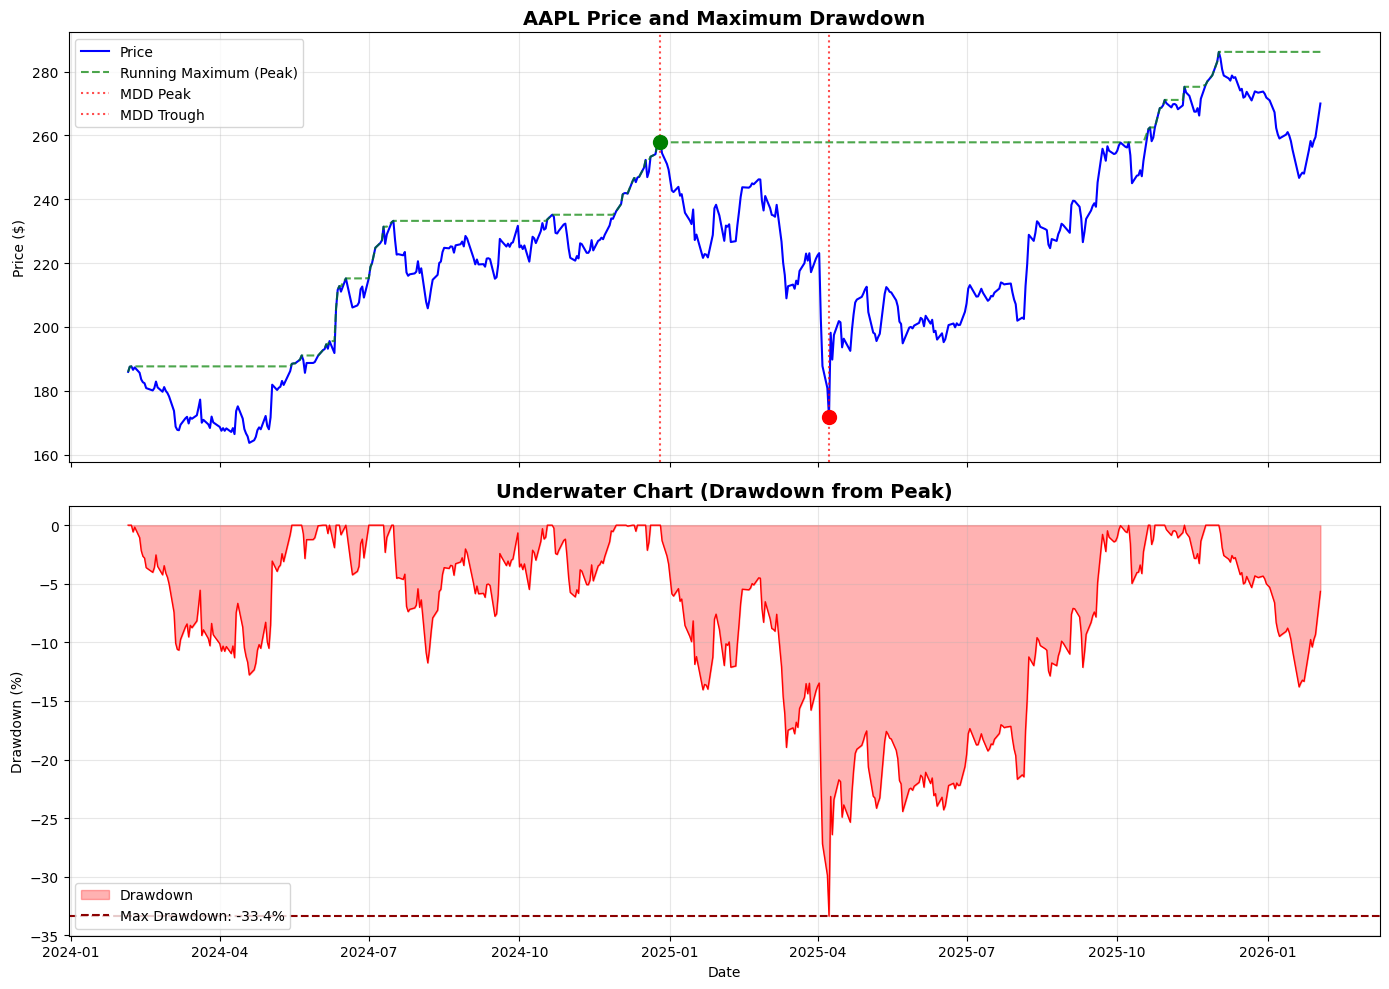

In [4]:
def plot_drawdown(prices, ticker):
    """Create a comprehensive drawdown visualization."""
    dd = calculate_drawdown(prices)

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Top: Price with running maximum
    ax1 = axes[0]
    ax1.plot(prices.index, prices, label='Price', color='blue', linewidth=1.5)
    ax1.plot(dd['running_max'].index, dd['running_max'],
             label='Running Maximum (Peak)', color='green', linestyle='--', alpha=0.7)

    # Mark the max drawdown period
    ax1.axvline(dd['peak_date'], color='red', linestyle=':', alpha=0.7, label='MDD Peak')
    ax1.axvline(dd['trough_date'], color='red', linestyle=':', alpha=0.7, label='MDD Trough')

    ax1.scatter([dd['peak_date']], [dd['peak_value']], color='green', s=100, zorder=5)
    ax1.scatter([dd['trough_date']], [dd['trough_value']], color='red', s=100, zorder=5)

    ax1.set_ylabel('Price ($)')
    ax1.set_title(f'{ticker} Price and Maximum Drawdown', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Bottom: Drawdown underwater chart
    ax2 = axes[1]
    ax2.fill_between(dd['drawdown_series'].index, dd['drawdown_series'] * 100, 0,
                     color='red', alpha=0.3, label='Drawdown')
    ax2.plot(dd['drawdown_series'].index, dd['drawdown_series'] * 100,
             color='red', linewidth=1)

    # Mark max drawdown
    ax2.axhline(dd['max_dd_pct'], color='darkred', linestyle='--',
                label=f'Max Drawdown: {dd["max_dd_pct"]:.1f}%')

    ax2.set_ylabel('Drawdown (%)')
    ax2.set_xlabel('Date')
    ax2.set_title('Underwater Chart (Drawdown from Peak)', fontsize=14, fontweight='bold')
    ax2.legend(loc='lower left')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return dd

# Visualize
dd_results = plot_drawdown(prices, ticker)

## Drawdown Duration and Recovery

Two additional metrics matter:

1. **Drawdown Duration:** How long from peak to trough?
2. **Recovery Time:** How long to reach a new peak?

Together these tell you how long your money was "underwater."

In [7]:
def analyze_drawdown_periods(prices):
    """Analyze all drawdown periods, not just the maximum.

    Returns list of drawdown periods with start, end, recovery dates.
    """
    running_max = prices.cummax()
    drawdown = (prices - running_max) / running_max

    # Find drawdown periods (when drawdown < 0)
    in_drawdown = drawdown < 0

    # Find transitions (start and end of drawdowns)
    transitions = in_drawdown.astype(int).diff()

    starts = transitions[transitions == 1].index.tolist()
    ends = transitions[transitions == -1].index.tolist()

    # Handle edge cases
    if in_drawdown.iloc[0]:
        starts = [prices.index[0]] + starts
    if in_drawdown.iloc[-1]:
        ends = ends + [prices.index[-1]]

    periods = []
    for start, end in zip(starts, ends):
        period_dd = drawdown[start:end]
        if len(period_dd) > 0:
            trough_date = period_dd.idxmin()
            max_dd = period_dd.min()

            # Calculate durations
            decline_days = (trough_date - start).days
            recovery_days = (end - trough_date).days
            total_days = (end - start).days

            periods.append({
                'start': start,
                'trough': trough_date,
                'end': end,
                'max_drawdown_pct': max_dd * 100,
                'decline_days': decline_days,
                'recovery_days': recovery_days,
                'total_underwater_days': total_days
            })

    return periods

# Analyze all drawdown periods
periods = analyze_drawdown_periods(prices)

# Show the worst 5 drawdowns
periods_df = pd.DataFrame(periods)
if len(periods_df) > 0:
    worst_5 = periods_df.nsmallest(5, 'max_drawdown_pct')

    print(f"Top 5 Worst Drawdowns for {ticker}")
    print("=" * 80)
    print(f"{'Rank':<6} {'Drawdown':>10} {'Decline':>12} {'Recovery':>12} {'Total Days':>12}")
    print("-" * 80)

    for i, (_, row) in enumerate(worst_5.iterrows(), 1):
        print(f"{i:<6} {row['max_drawdown_pct']:>9.1f}% {row['decline_days']:>10} days {row['recovery_days']:>10} days {row['total_underwater_days']:>10} days")
else:
    print("No drawdown periods found (stock only went up!)")

Top 5 Worst Drawdowns for AAPL
Rank     Drawdown      Decline     Recovery   Total Days
--------------------------------------------------------------------------------
1          -33.4%        101 days        195 days        296 days
2          -13.8%         48 days         13 days         61 days
3          -12.8%         70 days         26 days         96 days
4          -11.7%         20 days         73 days         93 days
5           -6.1%         13 days         25 days         38 days


## Comparing Drawdowns Across Investments

Drawdown is crucial for comparing investments with similar returns but different risk profiles.

In [9]:
def compare_drawdowns(tickers, period="2y"):
    """Compare maximum drawdowns across multiple investments."""
    results = []

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period=period)

            if len(hist) == 0:
                continue

            prices = hist['Close']
            dd = calculate_drawdown(prices)

            # Also calculate total return for context
            total_return = (prices.iloc[-1] / prices.iloc[0] - 1) * 100

            results.append({
                'ticker': ticker,
                'total_return_pct': total_return,
                'max_drawdown_pct': dd['max_dd_pct'],
                'peak_date': dd['peak_date'],
                'trough_date': dd['trough_date']
            })
        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    return pd.DataFrame(results)

# Compare several investments
comparison_tickers = ["AAPL", "NVDA", "MSFT", "GOOGL", "SPY", "QQQ"]
comparison = compare_drawdowns(comparison_tickers)

# Sort by max drawdown (least bad first)
comparison = comparison.sort_values('max_drawdown_pct', ascending=False)

print("Drawdown Comparison (2 Years)")
print("=" * 60)
print(f"{'Ticker':<8} {'Return':>12} {'Max Drawdown':>15} {'Return/DD':>12}")
print("-" * 60)

for _, row in comparison.iterrows():
    # Return-to-Drawdown ratio (higher is better)
    if row['max_drawdown_pct'] != 0:
        return_dd_ratio = row['total_return_pct'] / abs(row['max_drawdown_pct'])
    else:
        return_dd_ratio = float('inf')
    print(f"{row['ticker']:<8} {row['total_return_pct']:>+11.1f}% {row['max_drawdown_pct']:>14.1f}% {return_dd_ratio:>11.2f}x")

print("-" * 60)
print("\nReturn/DD Ratio: How much return per unit of max drawdown risk")
print("Higher is better (more return for less drawdown pain)")

Drawdown Comparison (2 Years)
Ticker         Return    Max Drawdown    Return/DD
------------------------------------------------------------
SPY            +44.7%          -18.8%        2.38x
QQQ            +47.8%          -22.8%        2.10x
MSFT            +5.9%          -23.7%        0.25x
GOOGL         +141.0%          -29.8%        4.73x
AAPL           +45.2%          -33.4%        1.36x
NVDA          +167.9%          -36.9%        4.55x
------------------------------------------------------------

Return/DD Ratio: How much return per unit of max drawdown risk
Higher is better (more return for less drawdown pain)


## Visualizing Comparative Drawdowns

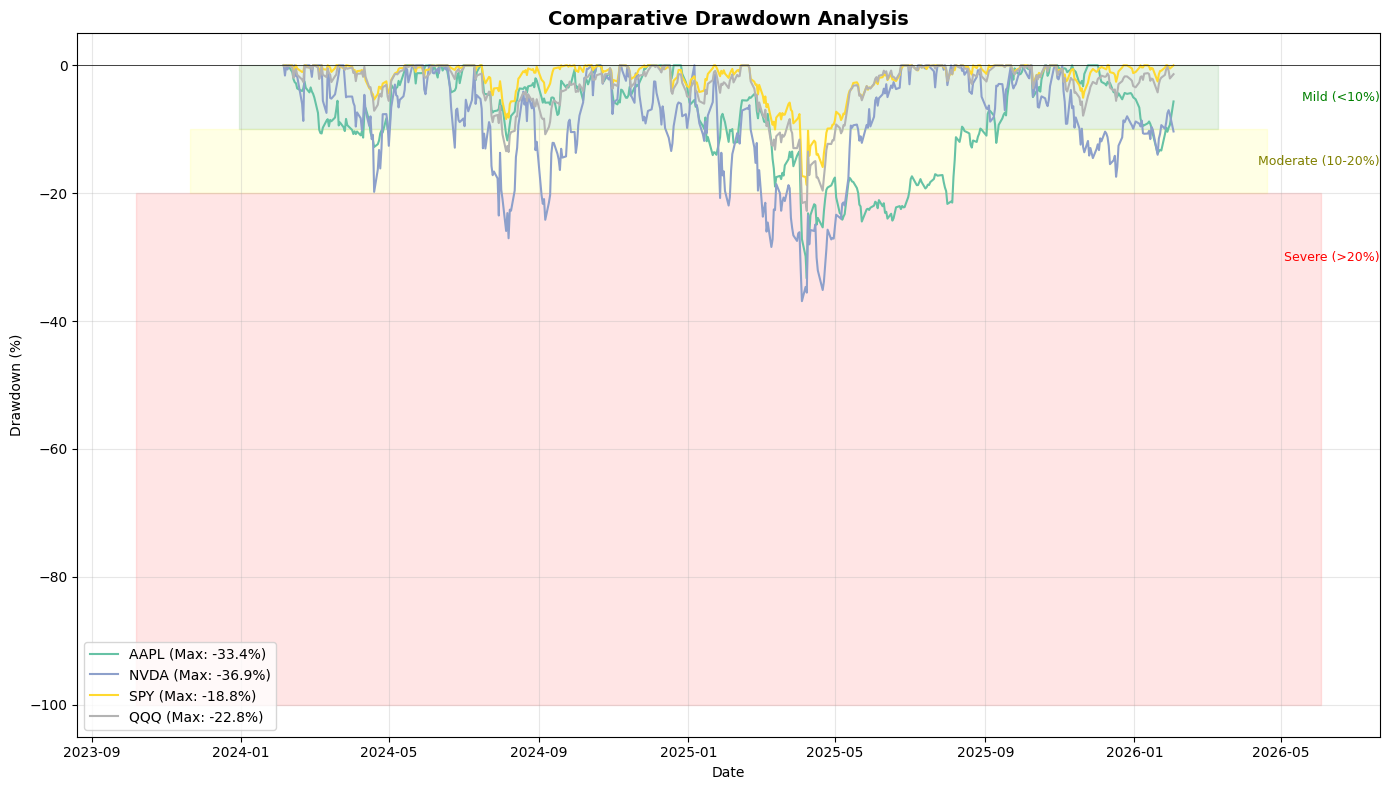

In [10]:
def plot_comparative_drawdowns(tickers, period="2y"):
    """Plot drawdowns for multiple investments on the same chart."""
    fig, ax = plt.subplots(figsize=(14, 8))

    colors = plt.cm.Set2(np.linspace(0, 1, len(tickers)))

    for ticker, color in zip(tickers, colors):
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period=period)

            if len(hist) == 0:
                continue

            prices = hist['Close']
            dd = calculate_drawdown(prices)

            ax.plot(dd['drawdown_series'].index, dd['drawdown_series'] * 100,
                   label=f"{ticker} (Max: {dd['max_dd_pct']:.1f}%)",
                   color=color, linewidth=1.5)
        except Exception as e:
            print(f"Error plotting {ticker}: {e}")

    ax.axhline(0, color='black', linewidth=0.5)
    ax.fill_between(ax.get_xlim(), -10, 0, color='green', alpha=0.1)
    ax.fill_between(ax.get_xlim(), -20, -10, color='yellow', alpha=0.1)
    ax.fill_between(ax.get_xlim(), -100, -20, color='red', alpha=0.1)

    ax.set_ylabel('Drawdown (%)')
    ax.set_xlabel('Date')
    ax.set_title('Comparative Drawdown Analysis', fontsize=14, fontweight='bold')
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)

    # Add zone labels
    ax.text(ax.get_xlim()[1], -5, 'Mild (<10%)', ha='right', va='center', fontsize=9, color='green')
    ax.text(ax.get_xlim()[1], -15, 'Moderate (10-20%)', ha='right', va='center', fontsize=9, color='olive')
    ax.text(ax.get_xlim()[1], -30, 'Severe (>20%)', ha='right', va='center', fontsize=9, color='red')

    plt.tight_layout()
    plt.show()

# Compare drawdowns visually
plot_comparative_drawdowns(["AAPL", "NVDA", "SPY", "QQQ"])

## Calmar Ratio: Return per Unit of Drawdown

The **Calmar Ratio** combines return and maximum drawdown into a single metric.

$$\text{Calmar Ratio} = \frac{\text{Annualized Return}}{|\text{Maximum Drawdown}|}$$

**Interpretation:**
- Higher is better
- A ratio of 1.0 means you earned 1% return for every 1% of drawdown risk
- Professional hedge funds often target Calmar > 1.0

In [11]:
def calculate_calmar_ratio(prices, periods_per_year=252):
    """Calculate the Calmar Ratio.

    Args:
        prices: Series of prices
        periods_per_year: Trading days per year (252 for daily)

    Returns:
        Dictionary with Calmar ratio and components
    """
    # Calculate annualized return
    total_return = prices.iloc[-1] / prices.iloc[0] - 1
    n_periods = len(prices)
    years = n_periods / periods_per_year
    annualized_return = (1 + total_return) ** (1 / years) - 1

    # Calculate max drawdown
    dd = calculate_drawdown(prices)
    max_dd = abs(dd['max_drawdown'])

    # Calmar ratio
    calmar = annualized_return / max_dd if max_dd > 0 else float('inf')

    return {
        'annualized_return_pct': annualized_return * 100,
        'max_drawdown_pct': dd['max_dd_pct'],
        'calmar_ratio': calmar
    }

# Calculate Calmar for comparison stocks
print("Calmar Ratio Analysis")
print("=" * 65)
print(f"{'Ticker':<8} {'Ann. Return':>14} {'Max Drawdown':>15} {'Calmar':>12}")
print("-" * 65)

for ticker in ["AAPL", "NVDA", "MSFT", "GOOGL", "SPY"]:
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period="3y")
        calmar = calculate_calmar_ratio(hist['Close'])
        print(f"{ticker:<8} {calmar['annualized_return_pct']:>+13.1f}% {calmar['max_drawdown_pct']:>14.1f}% {calmar['calmar_ratio']:>11.2f}")
    except Exception as e:
        print(f"{ticker:<8} Error: {e}")

print("-" * 65)
print("\nCalmar > 1.0 is generally considered good")
print("Calmar > 2.0 is excellent (high return, low drawdown)")

Calmar Ratio Analysis
Ticker      Ann. Return    Max Drawdown       Calmar
-----------------------------------------------------------------
AAPL             +21.2%          -33.4%        0.64
NVDA            +107.5%          -36.9%        2.91
MSFT             +19.0%          -23.7%        0.80
GOOGL            +49.3%          -29.8%        1.66
SPY              +20.8%          -18.8%        1.11
-----------------------------------------------------------------

Calmar > 1.0 is generally considered good
Calmar > 2.0 is excellent (high return, low drawdown)


## Portfolio Drawdown

For a portfolio, we need to calculate the combined drawdown based on position weights.

In [13]:
def calculate_portfolio_drawdown(holdings, period="2y"):
    """Calculate drawdown for a weighted portfolio.

    Args:
        holdings: Dict of {ticker: weight} where weights sum to 1.0
        period: Historical period to analyze
    """
    # Get price data for all holdings
    prices_dict = {}
    for ticker in holdings.keys():
        stock = yf.Ticker(ticker)
        hist = stock.history(period=period)
        prices_dict[ticker] = hist['Close']

    # Combine into DataFrame
    prices_df = pd.DataFrame(prices_dict).dropna()

    # Normalize prices to start at 1.0
    normalized = prices_df / prices_df.iloc[0]

    # Calculate weighted portfolio value
    portfolio_value = pd.Series(0.0, index=normalized.index)
    for ticker, weight in holdings.items():
        portfolio_value += normalized[ticker] * weight

    # Calculate portfolio drawdown
    dd = calculate_drawdown(portfolio_value)

    # Also get individual stock drawdowns for comparison
    individual_dd = {}
    for ticker in holdings.keys():
        ind_dd = calculate_drawdown(prices_df[ticker])
        individual_dd[ticker] = ind_dd['max_dd_pct']

    return {
        'portfolio_drawdown': dd,
        'portfolio_value': portfolio_value,
        'individual_drawdowns': individual_dd
    }

# Example portfolio
portfolio = {
    'AAPL': 0.25,
    'MSFT': 0.25,
    'GOOGL': 0.25,
    'NVDA': 0.25
}

port_dd = calculate_portfolio_drawdown(portfolio)

print("Portfolio vs Individual Drawdowns")
print("=" * 50)
print(f"\nPortfolio Max Drawdown: {port_dd['portfolio_drawdown']['max_dd_pct']:.1f}%")
print(f"\nIndividual Stock Drawdowns:")
for ticker, dd in port_dd['individual_drawdowns'].items():
    print(f"  {ticker}: {dd:.1f}%")

avg_individual = np.mean(list(port_dd['individual_drawdowns'].values()))
print(f"\nAverage Individual: {avg_individual:.1f}%")
print(f"Portfolio:          {port_dd['portfolio_drawdown']['max_dd_pct']:.1f}%")
print(f"\nDiversification Benefit: {abs(avg_individual) - abs(port_dd['portfolio_drawdown']['max_dd_pct']):.1f}% lower drawdown")

Portfolio vs Individual Drawdowns

Portfolio Max Drawdown: -28.7%

Individual Stock Drawdowns:
  AAPL: -33.4%
  MSFT: -23.7%
  GOOGL: -29.8%
  NVDA: -36.9%

Average Individual: -30.9%
Portfolio:          -28.7%

Diversification Benefit: 2.2% lower drawdown


## Key Takeaways

### Formulas You've Learned:

1. **Drawdown** = (Peak - Current) / Peak

2. **Maximum Drawdown** = Largest drawdown in period

3. **Calmar Ratio** = Annualized Return / |Max Drawdown|

4. **Recovery Requirement** = 1 / (1 - Loss%) - 1

### Key Concepts:

- **Drawdown measures downside risk** from peaks, not starting points
- **Recovery is asymmetric:** Losses require larger gains to recover
- **Time underwater matters:** Duration shows how long you wait to recover
- **Diversification helps:** Portfolio drawdown is usually less than individual stock drawdowns

### Why This Matters for AI Agents:

When we build AI agents, they'll need to:
- Monitor portfolio drawdowns in real-time
- Alert when drawdowns exceed thresholds
- Compare strategies by risk-adjusted metrics
- Suggest portfolio adjustments to limit drawdown risk

**Next Notebook:** We'll learn about correlation and diversification - understanding how assets move together.